## **Intro**

This notebook provides evaluation on various distributions with analytical ground truth mutual information. It is worth noting that InfoNet has **only been trained with gaussian mixture data**. These distributions are totally unseen for the infonet, which shows the strong generalization ability of InfoNet.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
## path to the root directory
%cd /content/drive/MyDrive/InfoNet-main
print("Current working directory:", os.getcwd())

/content/drive/MyDrive/InfoNet-main
Current working directory: /content/drive/MyDrive/InfoNet-main


Import packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
import torch
from model.decoder import Decoder
from model.encoder import Encoder
from model.infonet import infonet
from model.query import Query_Gen_transformer
from scipy.stats import rankdata
from scipy.special import digamma
from scipy.stats import gamma

from baseline.KSG import kraskov_mi
from baseline.MINE import MINE_esti

66817


Generate samples from several distributions along with their ground truth mutual information.

In [4]:
def gauss(rou, seq_len):
    sample = np.random.multivariate_normal(mean=[0,0], cov=[[1,rou],[rou,1]], size=seq_len)
    mutual_information = -np.log(1-rou**2)/2
    return sample, mutual_information

def half_cube_map(rou, seq_len):
    sample = np.random.multivariate_normal(mean=[0,0], cov=[[1,rou],[rou,1]], size=seq_len)
    x = sample[:, 0]
    y = sample[:, 1]
    x = np.sign(x) * np.abs(x)**(3/2)
    sample = np.stack((x, y), axis=1)
    mutual_information = -np.log(1-rou**2)/2
    return sample, mutual_information

def asinh_mapping(rou, seq_len):
    sample = np.random.multivariate_normal(mean=[0,0], cov=[[1,rou],[rou,1]], size=seq_len)
    x = sample[:, 0]
    y = sample[:, 1]
    x = np.log(x + np.sqrt(1 + x**2))
    sample = np.stack((x, y), axis=1)
    mutual_information = -np.log(1-rou**2)/2
    return sample, mutual_information

def additive_noise(epsilon, seq_len):

    x = np.random.uniform(0, 1, seq_len)

    noise = np.random.uniform(-epsilon, epsilon, seq_len)
    y = x + noise
    sample = np.stack((x, y), axis=1)

    if epsilon <= 0.5:
        mutual_information =  epsilon - np.log(2 * epsilon)
    else:
        mutual_information = 1 / (4 * epsilon)
    return sample, mutual_information

def gamma_exponential(alpha, seq_len):
    """
    Samples from a gamma-exponential distribution with parameter alpha
    and computes the mutual information of the sample.

    Parameters:
    alpha (float): The shape parameter for the gamma distribution.
    seq_len (int): The number of samples to draw.

    Returns:
    tuple: A tuple containing the samples from the gamma-exponential distribution
           and the true mutual information.
    """
    # Sample from the gamma distribution
    x_samples = gamma.rvs(alpha, size=seq_len)

    # Since the exponential parameter is derived from gamma sample (theta=1/X),
    # we use the sampled x to determine the scale for the exponential distribution.
    y_samples = np.random.exponential(scale=1/x_samples)

    # Compute the mutual information using the provided formula
    mutual_information = digamma(alpha + 1) - np.log(alpha)

    sample = np.stack((x_samples, y_samples), axis=1)

    return sample, mutual_information

In [5]:
## infonet infer
def infer(model, batch):
    ### batch has shape [batchsize, seq_len, 2]
    model.eval()
    batch = torch.tensor(batch, dtype=torch.float32, device=device)
    with torch.no_grad():

        mi_lb = model(batch)
        MI = torch.mean(mi_lb)

    return MI.cpu().numpy()

Load checkpoint and do estimation, compared results with other distributions.

In [6]:
latent_dim = 256
latent_num = 256
input_dim = 2
decoder_query_dim = 1000
global device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim=input_dim,
    latent_num=latent_num,
    latent_dim=latent_dim,
    cross_attn_heads=8,
    self_attn_heads=16,
    num_self_attn_per_block=8,
    num_self_attn_blocks=1
)

decoder = Decoder(
    q_dim=decoder_query_dim,
    latent_dim=latent_dim,
)

query_gen = Query_Gen_transformer(
    input_dim = input_dim,
    dim = decoder_query_dim
)

model = infonet(encoder=encoder, decoder=decoder, query_gen = query_gen, decoder_query_dim = decoder_query_dim).to(device)
ckpt_path = os.path.join('saved', 'uniform', 'model_5000_32_1000-600--0.20.pt')
model.load_state_dict(torch.load(ckpt_path, map_location=device))

<All keys matched successfully>

<ipython-input-5-28bd95a3de55>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32, device=device)


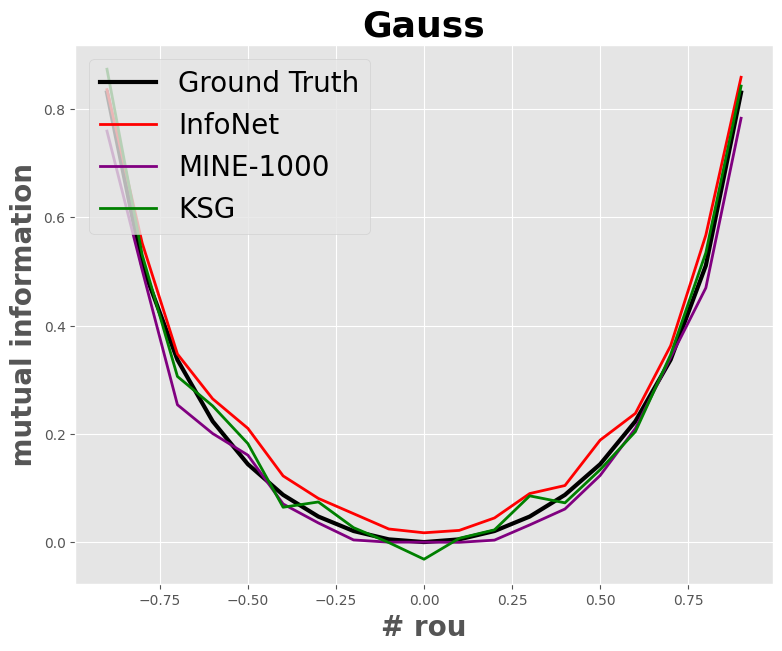

In [7]:
#### gauss

rou_list = np.arange(-0.9, 1, 0.1)
seq_len = 2000

mis_ksg = []
mis_mine_100 = []
mis_mine_1000 = []
mis_infonet = []
ground_truth = []
for rou in rou_list:
    sample, mutual_information = gauss(rou, seq_len)
    mi_mine_100 = MINE_esti(sample, batch_size=100, iter_num=int(100))
    mi_mine_1000 = MINE_esti(sample, batch_size=100, iter_num=int(1000))
    mi_ksg = kraskov_mi(sample[:, [0]], sample[:, [1]], k=3)

    rank_sample = sample
    rank_sample[:, 0] = rankdata(rank_sample[:, 0])/seq_len
    rank_sample[:, 1] = rankdata(rank_sample[:, 1])/seq_len
    mi_infonet = infer(model, torch.from_numpy(rank_sample).unsqueeze(0))
    ground_truth.append(mutual_information)
    mis_ksg.append(mi_ksg)
    mis_mine_100.append(mi_mine_100)
    mis_mine_1000.append(mi_mine_1000)
    mis_infonet.append(mi_infonet)

plt.style.use("ggplot")
fig = plt.figure(figsize=(9, 7))

ax1 = fig.add_subplot(111)

ax1.plot(rou_list, ground_truth, color="black", lw=3, ls="-", label="Ground Truth", markersize=10)
ax1.plot(rou_list, mis_infonet, color="red", lw=2, ls="-", label="InfoNet", markersize=10)
#ax1.plot(rou_list, mis_mine_100, color="blue", lw=2, ls="-", label="MINE-100", markersize=10)
ax1.plot(rou_list, mis_mine_1000, color="purple", lw=2, ls="-", label="MINE-1000", markersize=10)
ax1.plot(rou_list, mis_ksg, color="green", lw=2, ls="-", label="KSG", markersize=10)
ax1.set_xlabel("# rou", fontweight="bold", fontsize=20)
ax1.set_ylabel(" mutual information ", fontweight="bold", fontsize=20)
# ax1.tick_params(axis='x', which='major', labelsize=14, width=2, length=6)
# ax1.tick_params(axis='y', which='major', labelsize=14, width=2, length=6)
ax1.legend(fontsize=20, loc="upper left")

#image_save_path = os.path.join("plots", f"{name_distributions}.png")
#plt.savefig(image_save_path)
plt.title("Gauss", fontweight="bold", fontsize=26)
plt.show()

<ipython-input-5-28bd95a3de55>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32, device=device)


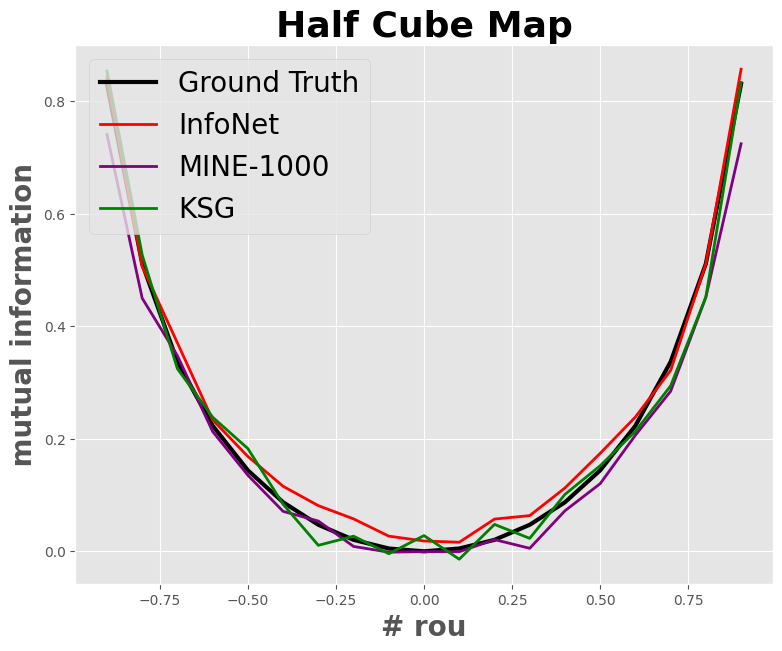

In [8]:
#### half cube map

rou_list = np.arange(-0.9, 1, 0.1)
seq_len = 2000

mis_ksg = []
mis_mine_100 = []
mis_mine_1000 = []
mis_infonet = []
ground_truth = []
for rou in rou_list:
    sample, mutual_information = half_cube_map(rou, seq_len)
    mi_mine_100 = MINE_esti(sample, batch_size=100, iter_num=int(100))
    mi_mine_1000 = MINE_esti(sample, batch_size=100, iter_num=int(1000))
    mi_ksg = kraskov_mi(sample[:, [0]], sample[:, [1]], k=3)

    rank_sample = sample
    rank_sample[:, 0] = rankdata(rank_sample[:, 0])/seq_len
    rank_sample[:, 1] = rankdata(rank_sample[:, 1])/seq_len
    mi_infonet = infer(model, torch.from_numpy(rank_sample).unsqueeze(0))
    ground_truth.append(mutual_information)
    mis_ksg.append(mi_ksg)
    mis_mine_100.append(mi_mine_100)
    mis_mine_1000.append(mi_mine_1000)
    mis_infonet.append(mi_infonet)

plt.style.use("ggplot")
fig = plt.figure(figsize=(9, 7))

ax1 = fig.add_subplot(111)

ax1.plot(rou_list, ground_truth, color="black", lw=3, ls="-", label="Ground Truth", markersize=10)
ax1.plot(rou_list, mis_infonet, color="red", lw=2, ls="-", label="InfoNet", markersize=10)
#ax1.plot(rou_list, mis_mine_100, color="blue", lw=2, ls="-", label="MINE-100", markersize=10)
ax1.plot(rou_list, mis_mine_1000, color="purple", lw=2, ls="-", label="MINE-1000", markersize=10)
ax1.plot(rou_list, mis_ksg, color="green", lw=2, ls="-", label="KSG", markersize=10)
ax1.set_xlabel("# rou", fontweight="bold", fontsize=20)
ax1.set_ylabel(" mutual information ", fontweight="bold", fontsize=20)
# ax1.tick_params(axis='x', which='major', labelsize=14, width=2, length=6)
# ax1.tick_params(axis='y', which='major', labelsize=14, width=2, length=6)
ax1.legend(fontsize=20, loc="upper left")

#image_save_path = os.path.join("plots", f"{name_distributions}.png")
#plt.savefig(image_save_path)
plt.title("Half Cube Map", fontweight="bold", fontsize=26)
plt.show()

<ipython-input-5-28bd95a3de55>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32, device=device)


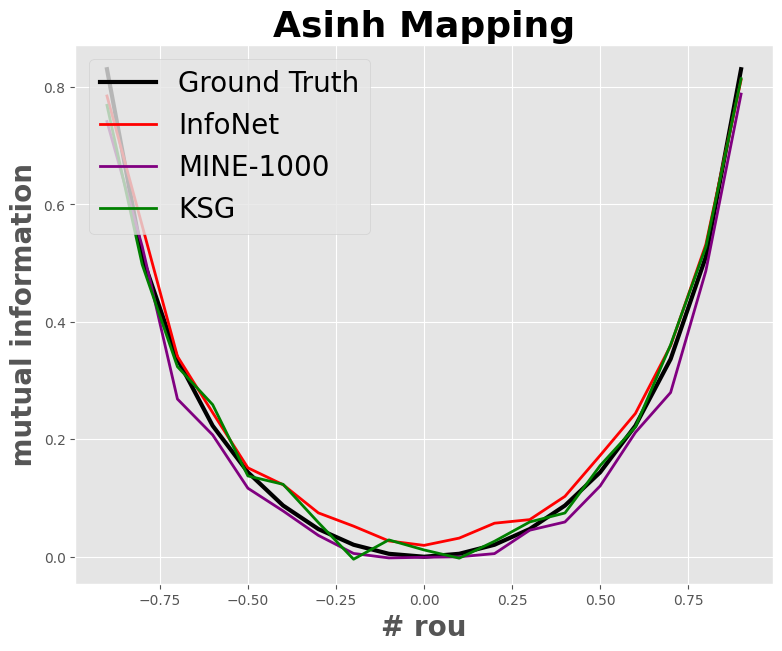

In [9]:
#### asinh mapping

rou_list = np.arange(-0.9, 1, 0.1)
seq_len = 2000

mis_ksg = []
mis_mine_100 = []
mis_mine_1000 = []
mis_infonet = []
ground_truth = []
for rou in rou_list:
    sample, mutual_information = asinh_mapping(rou, seq_len)
    mi_mine_100 = MINE_esti(sample, batch_size=100, iter_num=int(100))
    mi_mine_1000 = MINE_esti(sample, batch_size=100, iter_num=int(1000))
    mi_ksg = kraskov_mi(sample[:, [0]], sample[:, [1]], k=3)

    rank_sample = sample
    rank_sample[:, 0] = rankdata(rank_sample[:, 0])/seq_len
    rank_sample[:, 1] = rankdata(rank_sample[:, 1])/seq_len
    mi_infonet = infer(model, torch.from_numpy(rank_sample).unsqueeze(0))
    ground_truth.append(mutual_information)
    mis_ksg.append(mi_ksg)
    mis_mine_100.append(mi_mine_100)
    mis_mine_1000.append(mi_mine_1000)
    mis_infonet.append(mi_infonet)

plt.style.use("ggplot")
fig = plt.figure(figsize=(9, 7))

ax1 = fig.add_subplot(111)

ax1.plot(rou_list, ground_truth, color="black", lw=3, ls="-", label="Ground Truth", markersize=10)
ax1.plot(rou_list, mis_infonet, color="red", lw=2, ls="-", label="InfoNet", markersize=10)
#ax1.plot(rou_list, mis_mine_100, color="blue", lw=2, ls="-", label="MINE-100", markersize=10)
ax1.plot(rou_list, mis_mine_1000, color="purple", lw=2, ls="-", label="MINE-1000", markersize=10)
ax1.plot(rou_list, mis_ksg, color="green", lw=2, ls="-", label="KSG", markersize=10)
ax1.set_xlabel("# rou", fontweight="bold", fontsize=20)
ax1.set_ylabel(" mutual information ", fontweight="bold", fontsize=20)
# ax1.tick_params(axis='x', which='major', labelsize=14, width=2, length=6)
# ax1.tick_params(axis='y', which='major', labelsize=14, width=2, length=6)
ax1.legend(fontsize=20, loc="upper left")

#image_save_path = os.path.join("plots", f"{name_distributions}.png")
#plt.savefig(image_save_path)
plt.title("Asinh Mapping", fontweight="bold", fontsize=26)
plt.show()

<ipython-input-5-28bd95a3de55>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32, device=device)


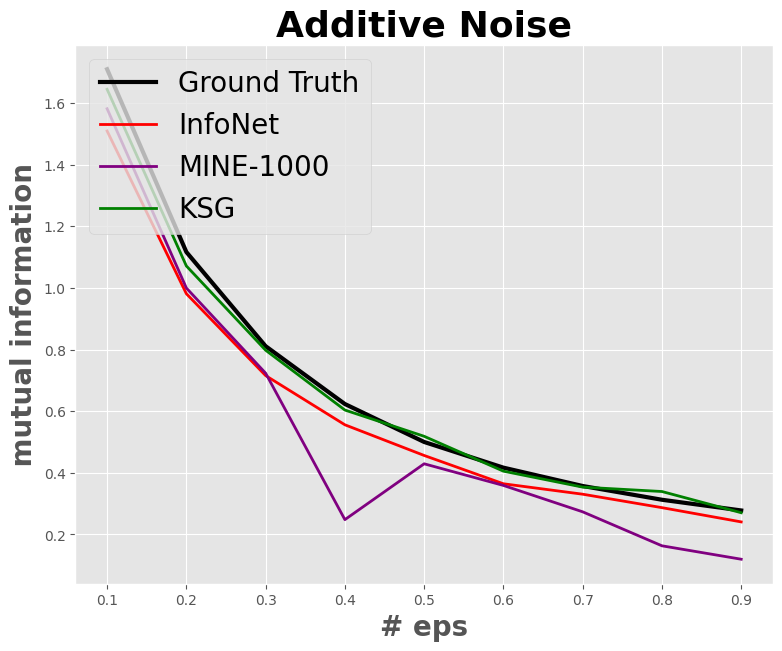

In [10]:
#### additive_noise

eps_list = np.arange(0.1, 1, 0.1)
seq_len = 2000

mis_ksg = []
mis_mine_100 = []
mis_mine_1000 = []
mis_infonet = []
ground_truth = []
for eps in eps_list:
    sample, mutual_information = additive_noise(eps, seq_len)
    mi_mine_100 = MINE_esti(sample, batch_size=100, iter_num=int(100))
    mi_mine_1000 = MINE_esti(sample, batch_size=100, iter_num=int(1000))
    mi_ksg = kraskov_mi(sample[:, [0]], sample[:, [1]], k=3)

    rank_sample = sample
    rank_sample[:, 0] = rankdata(rank_sample[:, 0])/seq_len
    rank_sample[:, 1] = rankdata(rank_sample[:, 1])/seq_len
    mi_infonet = infer(model, torch.from_numpy(rank_sample).unsqueeze(0))
    ground_truth.append(mutual_information)
    mis_ksg.append(mi_ksg)
    mis_mine_100.append(mi_mine_100)
    mis_mine_1000.append(mi_mine_1000)
    mis_infonet.append(mi_infonet)

plt.style.use("ggplot")
fig = plt.figure(figsize=(9, 7))

ax1 = fig.add_subplot(111)

ax1.plot(eps_list, ground_truth, color="black", lw=3, ls="-", label="Ground Truth", markersize=10)
ax1.plot(eps_list, mis_infonet, color="red", lw=2, ls="-", label="InfoNet", markersize=10)
#ax1.plot(eps_list, mis_mine_100, color="blue", lw=2, ls="-", label="MINE-100", markersize=10)
ax1.plot(eps_list, mis_mine_1000, color="purple", lw=2, ls="-", label="MINE-1000", markersize=10)
ax1.plot(eps_list, mis_ksg, color="green", lw=2, ls="-", label="KSG", markersize=10)
ax1.set_xlabel("# eps", fontweight="bold", fontsize=20)
ax1.set_ylabel(" mutual information ", fontweight="bold", fontsize=20)
# ax1.tick_params(axis='x', which='major', labelsize=14, width=2, length=6)
# ax1.tick_params(axis='y', which='major', labelsize=14, width=2, length=6)
ax1.legend(fontsize=20, loc="upper left")

#image_save_path = os.path.join("plots", f"{name_distributions}.png")
#plt.savefig(image_save_path)
plt.title("Additive Noise", fontweight="bold", fontsize=26)
plt.show()

<ipython-input-5-28bd95a3de55>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32, device=device)


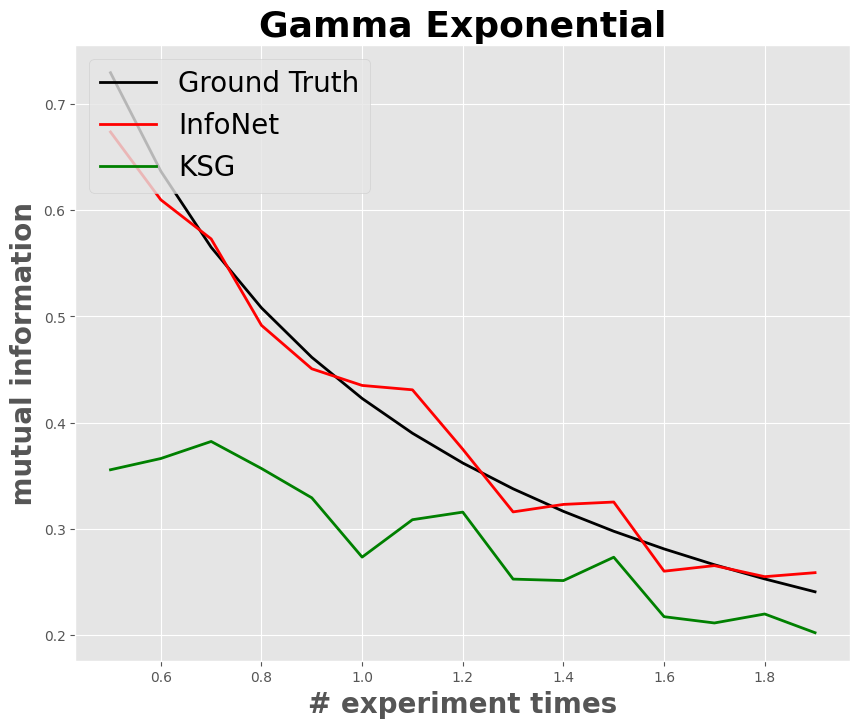

In [16]:
#### gamma exponential

alpha_list = np.arange(0.5, 2, 0.1)
seq_len = 2000

mis_ksg = []
mis_mine_100 = []
mis_mine_1000 = []
mis_infonet = []
ground_truth = []
for alpha in alpha_list:
    sample, mutual_information = gamma_exponential(alpha, seq_len)
    mi_mine_100 = MINE_esti(sample, batch_size=100, iter_num=int(100))
    mi_mine_1000 = MINE_esti(sample, batch_size=100, iter_num=int(1000))
    mi_ksg = kraskov_mi(sample[:, [0]], sample[:, [1]], k=3)

    rank_sample = sample
    rank_sample[:, 0] = rankdata(rank_sample[:, 0])/seq_len
    rank_sample[:, 1] = rankdata(rank_sample[:, 1])/seq_len
    mi_infonet = infer(model, torch.from_numpy(rank_sample).unsqueeze(0))
    ground_truth.append(mutual_information)
    mis_ksg.append(mi_ksg)
    mis_mine_100.append(mi_mine_100)
    mis_mine_1000.append(mi_mine_1000)
    mis_infonet.append(mi_infonet)

plt.style.use("ggplot")
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(111)

## MINE has unstable result on this distribution so the result will not shown
ax1.plot(alpha_list, ground_truth, color="black", lw=2, ls="-", label="Ground Truth", markersize=10)
ax1.plot(alpha_list, mis_infonet, color="red", lw=2, ls="-", label="InfoNet", markersize=10)
#ax1.plot(alpha_list, mis_mine_100, color="blue", lw=2, ls="-", label="MINE-100", markersize=10)
#ax1.plot(alpha_list, mis_mine_1000, color="purple", lw=2, ls="-", label="MINE-1000", markersize=10)
ax1.plot(alpha_list, mis_ksg, color="green", lw=2, ls="-", label="KSG", markersize=10)
ax1.set_xlabel("# experiment times", fontweight="bold", fontsize=20)
ax1.set_ylabel(" mutual information ", fontweight="bold", fontsize=20)
# ax1.tick_params(axis='x', which='major', labelsize=14, width=2, length=6)
# ax1.tick_params(axis='y', which='major', labelsize=14, width=2, length=6)
ax1.legend(fontsize=20, loc="upper left")

plt.title("Gamma Exponential", fontweight="bold", fontsize=26)
plt.show()